# 🧬💊 Deep Learning for Drug Sensitivity Prediction (GDSC)

## Project Overview
This notebook implements a **Dual-Tower Neural Network** (Multi-Modal) to predict the drug sensitivity (IC50) of cancer cell lines. It combines:
1.  **Genomic Features:** Cell line characteristics (Tissue type, Microsatellite instability, etc.).
2.  **Chemical Structure:** Drug SMILES strings processed via a 1D-CNN.

### Instructions for Colab
1.  **Upload Data:** Upload your `GDSC_DATASET.csv` (and optionally `Compounds-annotation.csv`) to the "Files" tab on the left.
2.  **Runtime:** Go to `Runtime` > `Change runtime type` > Select **T4 GPU** for faster training.
3.  **Run All:** Run all cells in order.

In [1]:
import os
import time
import pickle
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pubchempy as pcp

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Configure Logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Check GPU
print(f"TensorFlow Version: {tf.__version__}")
if tf.config.list_physical_devices('GPU'):
    print("✅ GPU Detected: Running on accelerated hardware.")
else:
    print("⚠️ No GPU Detected. Training might be slow. Go to Runtime > Change runtime type > GPU.")

2025-12-17 21:02:56.603243: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow Version: 2.20.0
✅ GPU Detected: Running on accelerated hardware.


In [2]:
# @title 2. Configuration & Constants
CONFIG = {
    'MAX_SMILES_LENGTH': 100,      # Max length for chemical string
    'EMBEDDING_DIM': 64,           # Size of drug vector space
    'DROPOUT_RATE': 0.3,           # Regularization
    'L2_REG': 1e-4,                # Weight decay
    'LEARNING_RATE': 1e-3,
    'BATCH_SIZE': 64,
    'EPOCHS': 50,
    'TARGET_COL': 'LN_IC50',       # The value we want to predict
    'DRUG_ID_COL': 'DRUG_ID',
    'DRUG_NAME_COL': 'DRUG_NAME',
    
    # Features from your Cell_Lines_Details file / GDSC_DATASET
    'CELL_FEATURES': [
        'GDSC Tissue descriptor 1', 
        'GDSC Tissue descriptor 2', 
        'TCGA_DESC',
        'Microsatellite instability Status (MSI)', 
        'Growth Properties',
        'CNA', 
        'Gene Expression', 
        'Methylation'
    ]
}

In [3]:
# @title 3. Helper Classes (Tokenizer & Encoder)

class SMILESTokenizer:
    """Converts SMILES text strings into integer sequences for the Neural Network."""
    def __init__(self, max_length=100):
        self.max_length = max_length
        self.char_to_idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx_to_char = {0: '<PAD>', 1: '<UNK>'}
        self.vocab_size = 2

    def fit(self, smiles_list):
        unique_chars = set()
        for s in smiles_list:
            if isinstance(s, str):
                unique_chars.update(set(s))
        
        for char in sorted(unique_chars):
            if char not in self.char_to_idx:
                self.char_to_idx[char] = self.vocab_size
                self.idx_to_char[self.vocab_size] = char
                self.vocab_size += 1
        return self

    def encode(self, smiles):
        if not isinstance(smiles, str):
            return [0] * self.max_length
        return [self.char_to_idx.get(c, 1) for c in smiles[:self.max_length]]

    def encode_batch(self, smiles_list):
        encoded = [self.encode(s) for s in smiles_list]
        return pad_sequences(encoded, maxlen=self.max_length, padding='post', truncating='post', value=0)

class CellFeatureEncoder:
    """Handles One-Hot/Label Encoding for categorical cell line features."""
    def __init__(self):
        self.encoders = {}
        self.scaler = StandardScaler()
        self.feature_names = []

    def fit_transform(self, df, feature_cols):
        self.feature_names = feature_cols
        processed_data = []
        
        for col in feature_cols:
            if col not in df.columns:
                print(f"⚠️ Warning: Feature '{col}' not found. Skipping.")
                continue
            
            # Handle Missing & Encode
            col_data = df[col].fillna('Unknown').astype(str)
            le = LabelEncoder()
            encoded_col = le.fit_transform(col_data)
            self.encoders[col] = le
            processed_data.append(encoded_col.reshape(-1, 1))
            
        if not processed_data:
            raise ValueError("No valid cell features found in dataset.")
            
        X_cat = np.hstack(processed_data)
        # Normalize so all inputs are on same scale
        X_norm = self.scaler.fit_transform(X_cat)
        return X_norm

In [4]:
# @title 4. Data Loading & Robust SMILES Fetching

def fetch_smiles_from_pubchem(drug_names, cache_file='smiles_cache.pkl'):
    """Fetches SMILES strings from PubChem if missing in dataset."""
    unique_drugs = sorted(list(set(drug_names)))
    smiles_map = {}
    
    # Load from cache if restart
    if os.path.exists(cache_file):
        with open(cache_file, 'rb') as f:
            smiles_map = pickle.load(f)

    drugs_to_fetch = [d for d in unique_drugs if d not in smiles_map]
    
    if drugs_to_fetch:
        print(f"🔍 Fetching SMILES for {len(drugs_to_fetch)} drugs from PubChem... (This may take a moment)")
        for i, drug in enumerate(drugs_to_fetch):
            try:
                compounds = pcp.get_compounds(drug, 'name')
                if compounds:
                    smiles_map[drug] = compounds[0].canonical_smiles
                else:
                    # Try simple cleanup
                    clean = drug.replace('-', ' ').replace('_', ' ')
                    compounds = pcp.get_compounds(clean, 'name')
                    smiles_map[drug] = compounds[0].canonical_smiles if compounds else None
            except:
                smiles_map[drug] = None
            
            # Progress bar simulation
            if i % 10 == 0: print('.', end='')
        
        print("\nDone fetching.")
        with open(cache_file, 'wb') as f:
            pickle.dump(smiles_map, f)
            
    return smiles_map

def load_gdsc_data():
    main_file = 'GDSC_DATASET.csv'
    
    if not os.path.exists(main_file):
        raise FileNotFoundError(f"❌ Could not find {main_file}. Please upload it to Colab Files!")
        
    df = pd.read_csv(main_file)
    print(f"✅ Loaded {main_file} with {len(df)} rows.")
    
    # --- SMILES Handling ---
    # 1. Check if SMILES exists in main file
    if 'SMILES' in df.columns:
        print("   SMILES column found.")
    # 2. Check annotation file
    elif os.path.exists('Compounds-annotation.csv'):
        print("   Merging SMILES from Compounds-annotation.csv...")
        annot = pd.read_csv('Compounds-annotation.csv')
        # Assumes annotation has DRUG_ID/NAME and SMILES column
        if 'SMILES' in annot.columns:
            df = df.merge(annot[[CONFIG['DRUG_ID_COL'], 'SMILES']], on=CONFIG['DRUG_ID_COL'], how='left')
    
    # 3. If still missing, fetch from web
    if 'SMILES' not in df.columns or df['SMILES'].isnull().sum() > len(df) * 0.5:
        print("   SMILES missing or incomplete. Fetching from PubChem API...")
        smiles_map = fetch_smiles_from_pubchem(df[CONFIG['DRUG_NAME_COL']].unique())
        df['SMILES'] = df[CONFIG['DRUG_NAME_COL']].map(smiles_map)
    
    # --- Cleaning ---
    initial_len = len(df)
    df = df.dropna(subset=['SMILES', CONFIG['TARGET_COL']])
    print(f"   Dropped {initial_len - len(df)} rows with missing SMILES or Targets.")
    
    # Remove Extreme Outliers (Z-score approach or Quantile)
    q_low = df[CONFIG['TARGET_COL']].quantile(0.01)
    q_high = df[CONFIG['TARGET_COL']].quantile(0.99)
    df = df[(df[CONFIG['TARGET_COL']] >= q_low) & (df[CONFIG['TARGET_COL']] <= q_high)]
    
    return df

# Load the dataset
try:
    df = load_gdsc_data()
    print(f"🚀 Final Dataset Size: {len(df)} samples")
    display(df.head(3))
except Exception as e:
    print(f"\nError: {e}")

✅ Loaded GDSC_DATASET.csv with 242035 rows.
   SMILES missing or incomplete. Fetching from PubChem API...
   Dropped 41796 rows with missing SMILES or Targets.
🚀 Final Dataset Size: 196233 samples


,COSMIC_ID,CELL_LINE_NAME,TCGA_DESC,DRUG_ID,DRUG_NAME,LN_IC50,AUC,Z_SCORE,GDSC Tissue descriptor 1,GDSC Tissue descriptor 2,Cancer Type (matching TCGA label),Microsatellite instability Status (MSI),Screen Medium,Growth Properties,CNA,Gene Expression,Methylation,TARGET,TARGET_PATHWAY,SMILES
0,683667,PFSK-1,MB,1003,Camptothecin,-1.463887,0.930220,0.433123,nervous_system,medulloblastoma,MB,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...
1,684057,ES5,UNCLASSIFIED,1003,Camptothecin,-3.360586,0.791072,-0.599569,bone,ewings_sarcoma,NaN,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...
2,684059,ES7,UNCLASSIFIED,1003,Camptothecin,-5.044940,0.592660,-1.516647,bone,ewings_sarcoma,NaN,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...


In [8]:
# @title 5. Preprocessing Pipeline

# 1. Process Cell Line Features
print("Encoding Cell Line Features...")
cell_encoder = CellFeatureEncoder()
X_cell = cell_encoder.fit_transform(df, CONFIG['CELL_FEATURES'])

# 2. Process Drug SMILES
print("Tokenizing SMILES strings...")
tokenizer = SMILESTokenizer(CONFIG['MAX_SMILES_LENGTH'])
tokenizer.fit(df['SMILES'].tolist())
X_drug = tokenizer.encode_batch(df['SMILES'].tolist())

# 3. Target Variable
y = df[CONFIG['TARGET_COL']].values.astype(np.float32)

# 4. Train/Val Split
X_cell_train, X_cell_val, X_drug_train, X_drug_val, y_train, y_val = train_test_split(
    X_cell, X_drug, y, test_size=0.2, random_state=42
)

print(f"\nData Shapes:")
print(f"X_cell_train: {X_cell_train.shape}")
print(f"X_drug_train: {X_drug_train.shape}")

Encoding Cell Line Features...
Tokenizing SMILES strings...

Data Shapes:
X_cell_train: (156986, 8)
X_drug_train: (156986, 100)


In [9]:
# @title 6. Build Model (Dual-Tower Architecture)


def create_dual_tower_model(cell_input_dim, vocab_size, max_len):
    # --- Tower A: Cell Line (Dense Network) ---
    cell_input = layers.Input(shape=(cell_input_dim,), name='cell_input')
    
    x_cell = layers.Dense(256, kernel_regularizer=regularizers.l2(5e-4))(cell_input)
    x_cell = layers.Activation('relu')(x_cell)
    x_cell = layers.BatchNormalization()(x_cell)
    x_cell = layers.Dropout(CONFIG['DROPOUT_RATE'])(x_cell)
    
    x_cell = layers.Dense(128, kernel_regularizer=regularizers.l2(5e-4))(x_cell)
    x_cell = layers.Activation('relu')(x_cell)
    x_cell = layers.BatchNormalization()(x_cell)


    # --- Tower B: Drug SMILES (1D-CNN) ---
    smiles_input = layers.Input(shape=(max_len,), name='smiles_input')
    
    # Embedding Layer (Integers -> Dense Vectors)
    x_drug = layers.Embedding(input_dim=vocab_size, 
                              output_dim=CONFIG['EMBEDDING_DIM'], 
                              input_length=max_len)(smiles_input)
    
    # Conv Block 1
    x_drug = layers.Conv1D(64, 5, padding='same', activation='relu', kernel_regularizer=regularizers.l2(5e-4))(x_drug)
    x_drug = layers.MaxPooling1D(2)(x_drug)
    
    # Conv Block 2
    x_drug = layers.Conv1D(128, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(5e-4))(x_drug)
    x_drug = layers.GlobalMaxPooling1D()(x_drug)
    x_drug = layers.Dropout(0.35)(x_drug)


    # --- Fusion (Merge Towers) ---
    concat = layers.Concatenate()([x_cell, x_drug])
    
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(5e-4))(concat)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(5e-4))(x)
    
    # Final Regression Head
    output = layers.Dense(1, name='ic50_prediction')(x)
    
    model = Model(inputs=[cell_input, smiles_input], outputs=output, name='GDSC_DualTower')
    return model


# Create and Compile
model = create_dual_tower_model(
    cell_input_dim=X_cell.shape[1],
    vocab_size=tokenizer.vocab_size,
    max_len=CONFIG['MAX_SMILES_LENGTH']
    )


model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=CONFIG['LEARNING_RATE']),
    loss='huber', # Robust to outliers compared to MSE
    metrics=['mae', 'mse']
    )


model.summary()

I0000 00:00:1765976669.772064   75116 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4149 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/elias/Dev/fac/taiwan/deeplearning/.venv/lib/python3.13/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "GDSC_DualTower"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cell_input          │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │      2,304 │ cell_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ smiles_input        │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256)       │          0 │ dense[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 64)   │      2,048 │ smiles_input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ activation[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 100, 64)   │     20,544 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 50, 64)    │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 50, 128)   │     24,704 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128)       │          0 │ dense_1[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ activation_1[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │     65,792 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │     16,448 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ic50_prediction     │ (None, 1)         │         65 │ dense_3[0][0]   

 Total params: 166,337 (649.75 KB)

 Trainable params: 165,569 (646.75 KB)

 Non-trainable params: 768 (3.00 KB)

In [11]:
# @title 7. Train Model

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    ModelCheckpoint('best_model.h5', save_best_only=True, verbose=0)
]

print("🚀 Starting Training...")
history = model.fit(
    [X_cell_train, X_drug_train], y_train,
    validation_data=([X_cell_val, X_drug_val], y_val),
    epochs=CONFIG['EPOCHS'],
    batch_size=CONFIG['BATCH_SIZE'],
    callbacks=callbacks,
    verbose=1
)

🚀 Starting Training...
Epoch 1/50
  67/2453 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.7328 - mae: 1.0729 - mse: 1.9437

2025-12-17 21:17:08.521465: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 62794400 exceeds 10% of free system memory.


2434/2453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7634 - mae: 1.1037 - mse: 2.1280

2025-12-17 21:17:14,310 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


2453/2453 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.7630 - mae: 1.1035 - mse: 2.1309 - val_loss: 0.7272 - val_mae: 1.0658 - val_mse: 1.9671 - learning_rate: 0.0010
Epoch 2/50
2431/2453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7555 - mae: 1.0970 - mse: 2.1108

2025-12-17 21:17:20,067 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


2453/2453 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.7553 - mae: 1.0977 - mse: 2.1080 - val_loss: 0.7261 - val_mae: 1.0644 - val_mse: 1.9944 - learning_rate: 0.0010
Epoch 3/50
2431/2453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7532 - mae: 1.0959 - mse: 2.1071

2025-12-17 21:17:25,872 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


2453/2453 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.7501 - mae: 1.0924 - mse: 2.0956 - val_loss: 0.7000 - val_mae: 1.0356 - val_mse: 1.9221 - learning_rate: 0.0010
Epoch 4/50
2453/2453 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.7449 - mae: 1.0878 - mse: 2.0799 - val_loss: 0.7040 - val_mae: 1.0418 - val_mse: 1.9458 - learning_rate: 0.0010
Epoch 5/50
2450/2453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7448 - mae: 1.0885 - mse: 2.0840

2025-12-17 21:17:36,839 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


2453/2453 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.7425 - mae: 1.0853 - mse: 2.0727 - val_loss: 0.6995 - val_mae: 1.0355 - val_mse: 1.9281 - learning_rate: 0.0010
Epoch 6/50
2453/2453 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.7407 - mae: 1.0834 - mse: 2.0711 - val_loss: 0.7098 - val_mae: 1.0501 - val_mse: 1.9418 - learning_rate: 0.0010
Epoch 7/50
2453/2453 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.7378 - mae: 1.0809 - mse: 2.0598 - val_loss: 0.7006 - val_mae: 1.0365 - val_mse: 1.9470 - learning_rate: 0.0010
Epoch 8/50
2447/2453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7335 - mae: 1.0759 - mse: 2.0448

2025-12-17 21:17:53,228 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


2453/2453 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.7346 - mae: 1.0770 - mse: 2.0509 - val_loss: 0.6941 - val_mae: 1.0314 - val_mse: 1.8972 - learning_rate: 0.0010
Epoch 9/50
2453/2453 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.7326 - mae: 1.0753 - mse: 2.0425 - val_loss: 0.7099 - val_mae: 1.0502 - val_mse: 1.9595 - learning_rate: 0.0010
Epoch 10/50
2447/2453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7329 - mae: 1.0753 - mse: 2.0456

2025-12-17 21:18:03,961 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


2453/2453 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.7319 - mae: 1.0747 - mse: 2.0420 - val_loss: 0.6939 - val_mae: 1.0297 - val_mse: 1.9334 - learning_rate: 0.0010
Epoch 11/50
2438/2453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7289 - mae: 1.0708 - mse: 2.0352

2025-12-17 21:18:09,242 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


2453/2453 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.7292 - mae: 1.0715 - mse: 2.0364 - val_loss: 0.6886 - val_mae: 1.0259 - val_mse: 1.8806 - learning_rate: 0.0010
Epoch 12/50
2453/2453 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.7274 - mae: 1.0709 - mse: 2.0282 - val_loss: 0.7038 - val_mae: 1.0453 - val_mse: 1.9356 - learning_rate: 0.0010
Epoch 13/50
2453/2453 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.7277 - mae: 1.0709 - mse: 2.0311 - val_loss: 0.7208 - val_mae: 1.0636 - val_mse: 2.0272 - learning_rate: 0.0010
Epoch 14/50
2440/2453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7234 - mae: 1.0668 - mse: 2.0110

2025-12-17 21:18:26,215 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


2453/2453 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.7263 - mae: 1.0698 - mse: 2.0273 - val_loss: 0.6821 - val_mae: 1.0202 - val_mse: 1.8695 - learning_rate: 0.0010
Epoch 15/50
2453/2453 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.7239 - mae: 1.0674 - mse: 2.0173 - val_loss: 0.7032 - val_mae: 1.0429 - val_mse: 1.9403 - learning_rate: 0.0010
Epoch 16/50
2453/2453 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.7254 - mae: 1.0689 - mse: 2.0232 - val_loss: 0.6904 - val_mae: 1.0292 - val_mse: 1.8887 - learning_rate: 0.0010
Epoch 17/50
2453/2453 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.7210 - mae: 1.0646 - mse: 2.0064 - val_loss: 0.6862 - val_mae: 1.0247 - val_mse: 1.8857 - learning_rate: 0.0010
Epoch 18/50
2453/2453 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.7212 - mae: 1.0651 - mse: 2.0085 - val_loss: 0.6894 - val_mae: 1.0297 - val_mse: 1.8926 - learning_rate: 0.0010
Epoch 19/50
2446/2453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7180 - mae: 1.0618 - mse: 2.0070
Epoch 19: ReduceLROnPlateau r

2025-12-17 21:20:55.964847: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-17 21:20:55.964894: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-17 21:20:56.346408: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_125', 8 bytes spill stores, 8 bytes spill loads

2025-12-17 21:20:56.705627: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Re

1227/1227 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step

FINAL RESULTS
Mean Squared Error: 1.8696
R2 Score:           0.7254


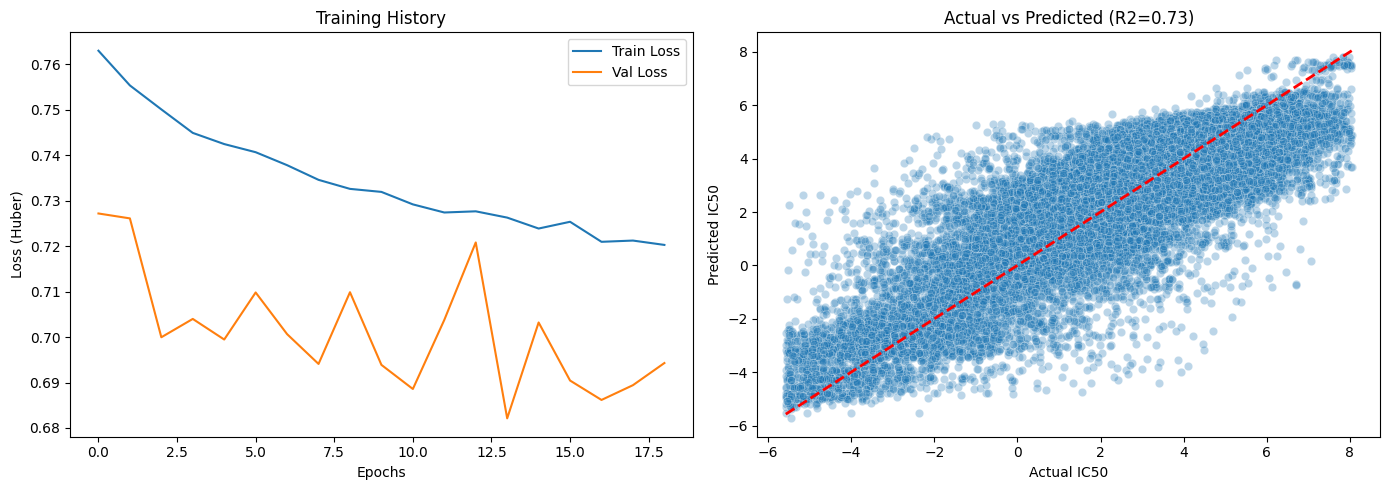

In [12]:
# @title 8. Evaluation & Visualization

# Predictions
preds = model.predict([X_cell_val, X_drug_val]).flatten()

# Metrics
mse = mean_squared_error(y_val, preds)
r2 = r2_score(y_val, preds)

print(f"\n{'='*30}")
print(f"FINAL RESULTS")
print(f"{'='*30}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R2 Score:           {r2:.4f}")
print(f"{'='*30}")

# Plots
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Loss Curve
ax[0].plot(history.history['loss'], label='Train Loss')
ax[0].plot(history.history['val_loss'], label='Val Loss')
ax[0].set_title('Training History')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (Huber)')
ax[0].legend()

# Preds vs Actual
sns.scatterplot(x=y_val, y=preds, ax=ax[1], alpha=0.3)
ax[1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
ax[1].set_xlabel('Actual IC50')
ax[1].set_ylabel('Predicted IC50')
ax[1].set_title(f'Actual vs Predicted (R2={r2:.2f})')

plt.tight_layout()
plt.show()